In [1]:
import os
import csv
import healpy as hp
import astropy.io.fits as fits
from astropy.table import vstack, Table
import numpy as np
import glob
import matplotlib.pyplot as plt
import sys
from matplotlib import cm
#import raichoorlib
import shutil
import matplotlib as mpl
from astroquery.gaia import Gaia
import astropy.units as u
from astropy.coordinates import SkyCoord
import fitsio
import scipy.integrate as integrate

import pyccl as ccl

In [2]:
# make plots prettier
import matplotlib
from matplotlib.pyplot import rc
import matplotlib.font_manager

rc('font',**{'size':'22','family':'serif','serif':['CMU serif']})
rc('mathtext', **{'fontset':'cm'})
rc('text', usetex=True)
rc('legend',**{'fontsize':'18'})

matplotlib.rcParams['axes.linewidth'] = 2
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 15 
matplotlib.rcParams['ytick.labelsize'] = 15
matplotlib.rcParams['legend.fontsize'] = 12
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['ytick.major.size'] = 10
matplotlib.rcParams['xtick.minor.size'] = 5
matplotlib.rcParams['ytick.minor.size'] = 5
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['xtick.minor.width'] = 1.5
matplotlib.rcParams['ytick.minor.width'] = 1.5
matplotlib.rcParams['xtick.direction'] = 'inout'
matplotlib.rcParams['ytick.direction'] = 'inout'
matplotlib.rcParams['axes.titlesize'] = 20
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

In [3]:
data_path = '/home/averdier/Documents/EPFL/DOCTORAT/WST/DECaLS/DATA_DR10/'
filenames = glob.glob(data_path + '*')
photo_z_file = glob.glob(data_path + '*pz*')[0]
data_file = glob.glob(data_path + '*0.fits*')[0]
cat_data = fitsio.FITS(data_file)
phot_data_SWEEP = fitsio.FITS(photo_z_file)

AREA_SWEEP = 18.28

In [4]:
filename_COSMOS = '/home/averdier/Documents/EPFL/DOCTORAT/WST/COSMOS/COSMOS2020.R1_v2.2-nochi2/COSMOS2020_CLASSIC_R1_v2.2_p3.fits'
data_COSMOS = fitsio.FITS(filename_COSMOS)

AREA_COSMOS = 3.42555

In [5]:
def get_BG_WST_Bright(cat,r_cut = 20.7):
    # 1) Get the columns needed to to the selection
    G_GAIA = cat[1].read('GAIA_PHOT_G_MEAN_MAG')
    FLUX_R = cat[1].read('FLUX_R')
    MW_R = cat[1].read('MW_TRANSMISSION_R')
    FIBER_FLUX_R = cat[1].read('FIBERFLUX_R')
    FIBERTOT_FLUX_R = cat[1].read('FIBERTOTFLUX_R')
    NOBS_R = cat[1].read('NOBS_R')
    NOBS_G = cat[1].read('NOBS_G')
    NOBS_Z = cat[1].read('NOBS_Z')
    FLUX_G = cat[1].read('FLUX_G')
    MW_G = cat[1].read('MW_TRANSMISSION_G')
    FLUX_Z = cat[1].read('FLUX_Z')
    MW_Z = cat[1].read('MW_TRANSMISSION_Z')
    MASKBITS = cat[1].read('MASKBITS')

    #2) Star-Galaxy Separation
    MAG_R_RAW = 22.5 - 2.5*np.log10(FLUX_R)
    
    #mask_SG |= ((G_GAIA - MAG_R_RAW > 0.6) & (G_GAIA == 0))
    not_in_gaia = cat[1].read('REF_CAT') == '  '
    mask_SG = ((G_GAIA - MAG_R_RAW) > 0.6) & ~not_in_gaia
    mask_SG |= not_in_gaia

    #3) Maskbits around bright stars
    mask_BS = ~(MASKBITS & 2**1 > 0)

    #4) Fiber Magnitude Cuts
    MAG_R = 22.5 - 2.5*np.log10(FLUX_R/MW_R)
    MAG_R_FIBER = 22.5 - 2.5*np.log10(FIBER_FLUX_R/MW_R)
    mask_FMC_1 = MAG_R < 17.8
    mask_FMC_1 &= MAG_R_FIBER < (22.9 + (MAG_R - 17.8))
    mask_FMC_2 = MAG_R > 17.8
    mask_FMC_2 &= MAG_R < r_cut + 0.5 # !! Had to modify this !! (Previously < 20)
    mask_FMC_2 &= MAG_R_FIBER < 22.9

    mask_FMC = mask_FMC_1 | mask_FMC_2

    #5) Quality Cuts
    MAG_G = 22.5 - 2.5*np.log10(FLUX_G/MW_G)
    MAG_Z = 22.5 - 2.5*np.log10(FLUX_Z/MW_Z)
    mask_QC_obs = (NOBS_R > 0) & (NOBS_G > 0) & (NOBS_Z > 0)
    mask_QC_1 = (MAG_G - MAG_R) > -1
    mask_QC_1 &= (MAG_G - MAG_R) < 4
    mask_QC_2 = (MAG_R - MAG_Z) > -1
    mask_QC_2 &= (MAG_R - MAG_Z) < 4
    mask_QC = mask_QC_1 | mask_QC_2
    
    mask_QC_tot = mask_QC_obs & mask_QC

    #6) Bright Limit
    MAG_R_FIBERTOT = 22.5 - 2.5*np.log10(FIBERTOT_FLUX_R/MW_R)
    mask_BL = MAG_R > 12
    mask_BL &= MAG_R_FIBERTOT < 15

    #7) MAG LIM
    mask_MAG_BG = MAG_R < r_cut

    mask_tot = mask_SG & mask_FMC & mask_QC_tot & ~mask_BL & mask_MAG_BG & mask_BS
    
    return mask_tot

In [6]:
def get_BG_WST_Faint(cat,r_cut_min=20.7,r_cut_max = 21.5):
    # 1) Get the columns needed to to the selection
    G_GAIA = cat[1].read('GAIA_PHOT_G_MEAN_MAG')
    FLUX_R = cat[1].read('FLUX_R')
    MW_R = cat[1].read('MW_TRANSMISSION_R')
    FIBER_FLUX_R = cat[1].read('FIBERFLUX_R')
    FIBERTOT_FLUX_R = cat[1].read('FIBERTOTFLUX_R')
    NOBS_R = cat[1].read('NOBS_R')
    NOBS_G = cat[1].read('NOBS_G')
    NOBS_Z = cat[1].read('NOBS_Z')
    FLUX_G = cat[1].read('FLUX_G')
    MW_G = cat[1].read('MW_TRANSMISSION_G')
    FLUX_Z = cat[1].read('FLUX_Z')
    MW_Z = cat[1].read('MW_TRANSMISSION_Z')
    MASKBITS = cat[1].read('MASKBITS')

    #2) Star-Galaxy Separation
    MAG_R_RAW = 22.5 - 2.5*np.log10(FLUX_R)
    
    #mask_SG |= ((G_GAIA - MAG_R_RAW > 0.6) & (G_GAIA == 0))
    not_in_gaia = cat[1].read('REF_CAT') == '  '
    mask_SG = ((G_GAIA - MAG_R_RAW) > 0.6) & ~not_in_gaia
    mask_SG |= not_in_gaia

    #3) Maskbits around bright stars
    mask_BS = ~(MASKBITS & 2**1 > 0)

    #4) Fiber Magnitude Cuts
    MAG_R = 22.5 - 2.5*np.log10(FLUX_R/MW_R)
    MAG_R_FIBER = 22.5 - 2.5*np.log10(FIBER_FLUX_R/MW_R)
    mask_FMC_1 = MAG_R < 17.8
    mask_FMC_1 &= MAG_R_FIBER < (22.9 + (MAG_R - 17.8))
    mask_FMC_2 = MAG_R > 17.8
    mask_FMC_2 &= MAG_R < r_cut_max + 0.5 # !! Had to modify this !! (Previously < 20)
    mask_FMC_2 &= MAG_R_FIBER < 22.9

    mask_FMC = mask_FMC_1 | mask_FMC_2

    #5) Quality Cuts
    MAG_G = 22.5 - 2.5*np.log10(FLUX_G/MW_G)
    MAG_Z = 22.5 - 2.5*np.log10(FLUX_Z/MW_Z)
    mask_QC_obs = (NOBS_R > 0) & (NOBS_G > 0) & (NOBS_Z > 0)
    mask_QC_1 = (MAG_G - MAG_R) > -1
    mask_QC_1 &= (MAG_G - MAG_R) < 4
    mask_QC_2 = (MAG_R - MAG_Z) > -1
    mask_QC_2 &= (MAG_R - MAG_Z) < 4
    mask_QC = mask_QC_1 | mask_QC_2
    
    mask_QC_tot = mask_QC_obs & mask_QC

    #6) Bright Limit
    MAG_R_FIBERTOT = 22.5 - 2.5*np.log10(FIBERTOT_FLUX_R/MW_R)
    mask_BL = MAG_R > 12
    mask_BL &= MAG_R_FIBERTOT < 15

    #7) MAG LIM
    mask_MAG_BG = (MAG_R > r_cut_min) & (MAG_R < r_cut_max)

    mask_tot = mask_SG & mask_FMC & mask_QC_tot & ~mask_BL & mask_MAG_BG & mask_BS
    
    return mask_tot

In [7]:
def get_LRG_WST(cat,z_cut=22.8):
    G_GAIA = cat[1].read('GAIA_PHOT_G_MEAN_MAG')
    FLUX_R = cat[1].read('FLUX_R')
    FLUX_IVAR_R = cat[1].read('FLUX_IVAR_R')
    MW_R = cat[1].read('MW_TRANSMISSION_R')
    NOBS_R = cat[1].read('NOBS_R')
    NOBS_G = cat[1].read('NOBS_G')
    NOBS_Z = cat[1].read('NOBS_Z')
    NOBS_W1 = cat[1].read('NOBS_W1')
    FLUX_G = cat[1].read('FLUX_G')
    FLUX_IVAR_G = cat[1].read('FLUX_IVAR_G')
    MW_G = cat[1].read('MW_TRANSMISSION_G')
    FLUX_Z = cat[1].read('FLUX_Z')
    FLUX_IVAR_Z = cat[1].read('FLUX_IVAR_Z')
    FIBER_FLUX_Z = cat[1].read('FIBERFLUX_Z')
    MW_Z = cat[1].read('MW_TRANSMISSION_Z')
    MASKBITS = cat[1].read('MASKBITS')
    WISEMASKS = cat[1].read('WISEMASK_W1')
    FLUX_W1 = cat[1].read('FLUX_W1')
    FLUX_IVAR_W1 = cat[1].read('FLUX_IVAR_W1')
    MW_W1 = cat[1].read('MW_TRANSMISSION_W1')

    #1) Clean 
    mask_clean = (NOBS_R > 0) & (NOBS_G > 0) & (NOBS_Z > 0) & (NOBS_W1 > 0)
    mask_clean &= (FLUX_IVAR_R > 0) & (FLUX_IVAR_G > 0) & (FLUX_IVAR_Z > 0) & (FLUX_IVAR_W1 > 0)


    #2) Maskbits & Wisemasks
    mask_bits = ~(MASKBITS & 2**1 > 0)
    mask_bits &= ~(MASKBITS & 2**11 > 0)
    mask_bits &= ~(MASKBITS & 2**12 > 0)
    mask_bits &= ~(MASKBITS & 2**13 > 0)
    mask_bits &= ~(WISEMASKS > 0)

    #3) GAIA cuts
    mask_Gaia = (G_GAIA > 18) | (G_GAIA == 0)

    #4) Fiber_z cuts
    FIBERZ_MAG = 22.5 - 2.5*np.log10(FIBER_FLUX_Z/MW_Z)
    mask_z_fiber = (FIBERZ_MAG > 17.5) & (FIBERZ_MAG < z_cut)

    # 5) cours cuts
    MAG_R = 22.5 - 2.5*np.log10(FLUX_R/MW_R)
    MAG_G = 22.5 - 2.5*np.log10(FLUX_G/MW_G)
    MAG_Z = 22.5 - 2.5*np.log10(FLUX_Z/MW_Z)
    MAG_W1 = 22.5 - 2.5*np.log10(FLUX_W1/MW_W1)
    mask_colour = (MAG_Z - MAG_W1) > 0.8*(MAG_R - MAG_Z) - 0.6
    mask_colour &= ((MAG_G - MAG_W1) > 2.9) | ((MAG_R - MAG_W1) > 1.8)
    mask_colour &= ((MAG_R - MAG_W1) > 1.8*(MAG_W1 - 17.14)) & ((MAG_R - MAG_W1) > (MAG_W1 - 16.33)) | (MAG_R - MAG_W1 > 3.3)

    mask_tot = mask_clean & mask_bits & mask_Gaia & mask_z_fiber & mask_colour
    #print(mask_clean.sum(),mask_bits.sum(),mask_Gaia.sum(),mask_z_fiber.sum(),mask_colour.sum())
    return mask_tot

In [8]:
def get_ELG_WST(cat_cosmo,g_cut=25.3):
    mag_r = cat_cosmo[1].read('HSC_r_MAG_APER2')
    mag_z = cat_cosmo[1].read('HSC_z_MAG_APER2')
    mag_g = cat_cosmo[1].read('HSC_g_MAG_APER2')
    #w1_mag = data.field('IRAC_CH1_MAG')
    photz = cat_cosmo[1].read('lp_zPDF')
    flags = cat_cosmo[1].read('FLAG_HSC')

    #1) Clean Sample
    mask_clean = (flags == 0)
    mask_clean &= (np.invert(np.isnan(mag_r))) & (np.invert(np.isnan(mag_g))) & (np.invert(np.isnan(mag_z)))
    mask_clean &= (np.invert(np.isnan(photz)))
    mask_clean &= photz < 1.6

    #2) Bright Cuts
    mask_bright = (mag_g > 20)
    mask_bright &= (mag_g < g_cut)

    #3) Colour Cuts
    #3.1) High z-cut
    mask_colour_1 = (0.15 < mag_r - mag_z)

    #3.2) Star/low-z cut
    mask_colour_2 = ((mag_g - mag_r) < 0.5*(mag_r - mag_z) + 0.1)

    #3.3) Redshift/[OII] cut
    mask_colour_3 = ((mag_g - mag_r) < -1.2*(mag_r - mag_z) + 1.6)

    mask_tot = mask_clean & mask_bright & mask_colour_2 & mask_colour_3

    plot=False
    if plot==True:
        rc = mag_r[mask_tot]
        gc = mag_g[mask_tot]
        zc = mag_z[mask_tot]
        pzc = photz[mask_tot]
        
        fig, ax = plt.subplots()
        cmap=mpl.cm.get_cmap('rainbow')
        cmap=mpl.colors.ListedColormap(cmap(np.linspace(0.0,1,len(mag_r))))
        sc = ax.scatter((rc-zc),(gc-rc),c=pzc,s=0.5,cmap=cmap)
        plt.xlabel('r-z')
        plt.ylabel('g-r')
        plt.colorbar(sc,label=r'Redshift')
        plt.xlim(-1,2)
        plt.ylim(-0.5,2)
        plt.show()
        plt.close()
    return mask_tot

In [9]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.677, A_s=2.1e-9, n_s=0.968,transfer_function='boltzmann_camb')
def E_z(z, Om0, Ol0):
   E = np.sqrt( Om0*(1+z)**3 +Ol0 )
   return E
def compute_dist(z_array):
   c = 299792.458
   dH = c / 100
   # Om0 = 0.292
   # Ol0 = 0.708
   # Om0 = 0.3075
   # Ol0 = 0.6925
   Om0 = 0.315191868
   Ol0 = 1 - Om0
   # Om0 = 0.30
   # Ol0 = 0.70
   comov_z = np.zeros(len(z_array))
   for i, z in enumerate(z_array):
      dist = comov_z[i] = dH * integrate.quad(lambda z: 1./E_z(z, Om0, Ol0), 0, z)[0]
   return comov_z
   
def compute_volume(bins_, Nz,AREA):
   A = AREA * (np.pi/180)**2
   z_val = np.array([(a + b) / 2.0 for a, b in zip(bins_[:-1], bins_[1:])])
   z_vol = (1/3)*A*np.array([(compute_dist([b])[0]**3 - compute_dist([a])[0]**3) for a, b in zip(bins_[:-1], bins_[1:])])
   nz3D = Nz / z_vol
   return z_val, nz3D

def get_3D_sample(photo_z_col,sample_mask,AREA):
    photo_z_sample = photo_z_col[sample_mask & (photo_z_col > 0)]
    print('Target Density : ' + str(len(photo_z_sample)/AREA))
    photz_liste = np.linspace(0,2,101)
    N_bins = np.histogram(photo_z_sample, bins = photz_liste)
    z_sample,n3D_sample = compute_volume(N_bins[1],N_bins[0],AREA)
    return z_sample, n3D_sample

In [10]:
def get_scaling_mag(diam_mirrror_desi, diam_mirrror_wst):
    delta_m = 2.5*np.log10(diam_mirrror_wst/diam_mirrror_desi)
    return delta_m

def get_mag_scaling_w_time(t_new, t_old):
    delta_m = 2.5*np.log10(np.sqrt(t_new/t_old))
    return delta_m

In [11]:
delta_m_miror = get_scaling_mag(4,12.5)

In [12]:
delta_m_miror

1.2371250542002352

In [13]:
delta_m_time = get_mag_scaling_w_time(1000,180)

In [14]:
delta_m_time

0.9309093686208675

In [15]:
MAG_R_CUT_BG_BRIGHT_DESI = 19.5
MAG_Z_CUT_LRG_DESI = 21.6
MAG_G_CUT_ELG_DESI = 24.1

In [16]:
MAG_R_CUT_BG_BRIGHT = MAG_R_CUT_BG_BRIGHT_DESI + delta_m_miror #20.7
MAG_R_CUT_BG_FAINT = MAG_R_CUT_BG_BRIGHT + delta_m_time #21.5
MAG_Z_CUT_LRG = MAG_Z_CUT_LRG_DESI + delta_m_miror #22.8
MAG_G_CUT_ELG = MAG_G_CUT_ELG_DESI + delta_m_miror #25.3
MAG_G_CUT_ELG_REAL = 24.82

In [17]:
MAG_R_CUT_BG_BRIGHT, MAG_R_CUT_BG_FAINT, MAG_Z_CUT_LRG, MAG_G_CUT_ELG

(20.737125054200234, 21.6680344228211, 22.837125054200236, 25.337125054200236)

In [20]:
BG_WST_Bright = get_BG_WST_Bright(cat_data,r_cut=MAG_R_CUT_BG_BRIGHT)
dens_WST_BG_Bright = BG_WST_Bright.sum()/AREA_SWEEP
print(dens_WST_BG_Bright,BG_WST_Bright.sum())

/tmp/ipykernel_31300/1400601344.py:18: RuntimeWarning: divide by zero encountered in log10
  MAG_R_RAW = 22.5 - 2.5*np.log10(FLUX_R)
/tmp/ipykernel_31300/1400601344.py:18: RuntimeWarning: invalid value encountered in log10
  MAG_R_RAW = 22.5 - 2.5*np.log10(FLUX_R)


2934.190371991247 53637


/tmp/ipykernel_31300/1400601344.py:29: RuntimeWarning: divide by zero encountered in log10
  MAG_R = 22.5 - 2.5*np.log10(FLUX_R/MW_R)
/tmp/ipykernel_31300/1400601344.py:29: RuntimeWarning: invalid value encountered in log10
  MAG_R = 22.5 - 2.5*np.log10(FLUX_R/MW_R)
/tmp/ipykernel_31300/1400601344.py:30: RuntimeWarning: divide by zero encountered in log10
  MAG_R_FIBER = 22.5 - 2.5*np.log10(FIBER_FLUX_R/MW_R)
/tmp/ipykernel_31300/1400601344.py:40: RuntimeWarning: divide by zero encountered in log10
  MAG_G = 22.5 - 2.5*np.log10(FLUX_G/MW_G)
/tmp/ipykernel_31300/1400601344.py:40: RuntimeWarning: invalid value encountered in log10
  MAG_G = 22.5 - 2.5*np.log10(FLUX_G/MW_G)
/tmp/ipykernel_31300/1400601344.py:41: RuntimeWarning: divide by zero encountered in log10
  MAG_Z = 22.5 - 2.5*np.log10(FLUX_Z/MW_Z)
/tmp/ipykernel_31300/1400601344.py:41: RuntimeWarning: invalid value encountered in log10
  MAG_Z = 22.5 - 2.5*np.log10(FLUX_Z/MW_Z)
/tmp/ipykernel_31300/1400601344.py:43: RuntimeWarning

In [21]:
BG_WST_Faint = get_BG_WST_Faint(cat_data,r_cut_min=MAG_R_CUT_BG_BRIGHT,r_cut_max=MAG_R_CUT_BG_FAINT)
dens_WST_BG_Faint = BG_WST_Faint.sum()/AREA_SWEEP
print(dens_WST_BG_Faint,BG_WST_Faint.sum())

/tmp/ipykernel_31300/4109138304.py:18: RuntimeWarning: divide by zero encountered in log10
  MAG_R_RAW = 22.5 - 2.5*np.log10(FLUX_R)
/tmp/ipykernel_31300/4109138304.py:18: RuntimeWarning: invalid value encountered in log10
  MAG_R_RAW = 22.5 - 2.5*np.log10(FLUX_R)


4250.984682713348 77708


/tmp/ipykernel_31300/4109138304.py:29: RuntimeWarning: divide by zero encountered in log10
  MAG_R = 22.5 - 2.5*np.log10(FLUX_R/MW_R)
/tmp/ipykernel_31300/4109138304.py:29: RuntimeWarning: invalid value encountered in log10
  MAG_R = 22.5 - 2.5*np.log10(FLUX_R/MW_R)
/tmp/ipykernel_31300/4109138304.py:30: RuntimeWarning: divide by zero encountered in log10
  MAG_R_FIBER = 22.5 - 2.5*np.log10(FIBER_FLUX_R/MW_R)
/tmp/ipykernel_31300/4109138304.py:40: RuntimeWarning: divide by zero encountered in log10
  MAG_G = 22.5 - 2.5*np.log10(FLUX_G/MW_G)
/tmp/ipykernel_31300/4109138304.py:40: RuntimeWarning: invalid value encountered in log10
  MAG_G = 22.5 - 2.5*np.log10(FLUX_G/MW_G)
/tmp/ipykernel_31300/4109138304.py:41: RuntimeWarning: divide by zero encountered in log10
  MAG_Z = 22.5 - 2.5*np.log10(FLUX_Z/MW_Z)
/tmp/ipykernel_31300/4109138304.py:41: RuntimeWarning: invalid value encountered in log10
  MAG_Z = 22.5 - 2.5*np.log10(FLUX_Z/MW_Z)
/tmp/ipykernel_31300/4109138304.py:43: RuntimeWarning

In [22]:
LRG_WST = get_LRG_WST(cat_data,z_cut=MAG_Z_CUT_LRG)
dens_WST_LRG = LRG_WST.sum()/AREA_SWEEP
print(dens_WST_LRG,LRG_WST.sum())

2509.5185995623633 45874


/tmp/ipykernel_31300/1637370276.py:39: RuntimeWarning: divide by zero encountered in log10
  FIBERZ_MAG = 22.5 - 2.5*np.log10(FIBER_FLUX_Z/MW_Z)
/tmp/ipykernel_31300/1637370276.py:43: RuntimeWarning: divide by zero encountered in log10
  MAG_R = 22.5 - 2.5*np.log10(FLUX_R/MW_R)
/tmp/ipykernel_31300/1637370276.py:43: RuntimeWarning: invalid value encountered in log10
  MAG_R = 22.5 - 2.5*np.log10(FLUX_R/MW_R)
/tmp/ipykernel_31300/1637370276.py:44: RuntimeWarning: divide by zero encountered in log10
  MAG_G = 22.5 - 2.5*np.log10(FLUX_G/MW_G)
/tmp/ipykernel_31300/1637370276.py:44: RuntimeWarning: invalid value encountered in log10
  MAG_G = 22.5 - 2.5*np.log10(FLUX_G/MW_G)
/tmp/ipykernel_31300/1637370276.py:45: RuntimeWarning: divide by zero encountered in log10
  MAG_Z = 22.5 - 2.5*np.log10(FLUX_Z/MW_Z)
/tmp/ipykernel_31300/1637370276.py:45: RuntimeWarning: invalid value encountered in log10
  MAG_Z = 22.5 - 2.5*np.log10(FLUX_Z/MW_Z)
/tmp/ipykernel_31300/1637370276.py:46: RuntimeWarning:

In [23]:
ELG_WST = get_ELG_WST(data_COSMOS,g_cut=MAG_G_CUT_ELG)
dens_WST_ELG = ELG_WST.sum()/AREA_COSMOS
print(dens_WST_ELG, ELG_WST.sum())

22164.615901096175 75926


In [22]:
tot_dens_WST = dens_WST_BG_Faint + dens_WST_LRG + dens_WST_ELG

In [23]:
print('Grey Time Tot = ',tot_dens_WST)

Grey Time Tot =  28925.119183371884


In [24]:
print('ELG Target Portion: ', dens_WST_ELG/tot_dens_WST)

ELG Target Portion:  0.7662756983154592


In [25]:
phot_z_SWEEP = phot_data_SWEEP[1].read('Z_PHOT_MEAN')
phot_z_COSMOS = data_COSMOS[1].read('lp_zPDF')

In [26]:
photz_liste = np.linspace(0,2,101)
Nz_BG_BRIGHT = np.histogram(phot_z_SWEEP[BG_WST_Bright], bins = photz_liste)
Nz_BG_FAINT = np.histogram(phot_z_SWEEP[BG_WST_Faint],bins=photz_liste)
Nz_BG_TOT = Nz_BG_BRIGHT[0] + Nz_BG_FAINT[0]
Nz_LRG = np.histogram(phot_z_SWEEP[LRG_WST], bins=photz_liste)
Nz_ELG = np.histogram(phot_z_COSMOS[ELG_WST], bins=photz_liste)

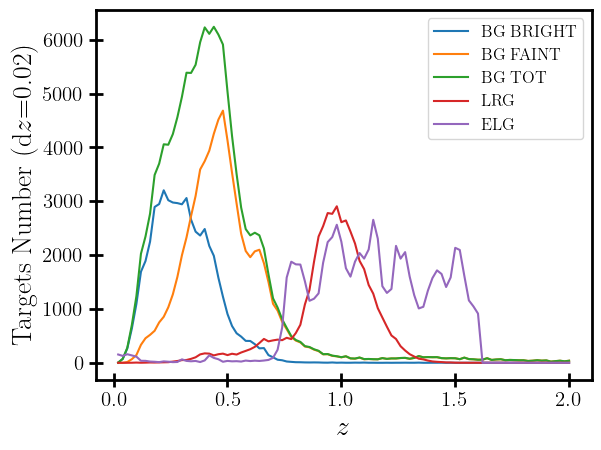

In [27]:
plt.plot(Nz_BG_BRIGHT[1][1::],Nz_BG_BRIGHT[0],label='BG BRIGHT')
plt.plot(Nz_BG_FAINT[1][1::],Nz_BG_FAINT[0],label='BG FAINT')
plt.plot(Nz_BG_BRIGHT[1][1::],(Nz_BG_TOT),label = 'BG TOT')
plt.plot(Nz_LRG[1][1::],Nz_LRG[0],label='LRG')
plt.plot(Nz_ELG[1][1::],Nz_ELG[0],label='ELG')
plt.xlabel(r'$z$')
plt.ylabel(r'Targets Number (d$z$=0.02)')
plt.legend()
plt.show()
plt.close()

In [96]:
Nz_LRG[0].sum()/AREA_SWEEP

2509.354485776805

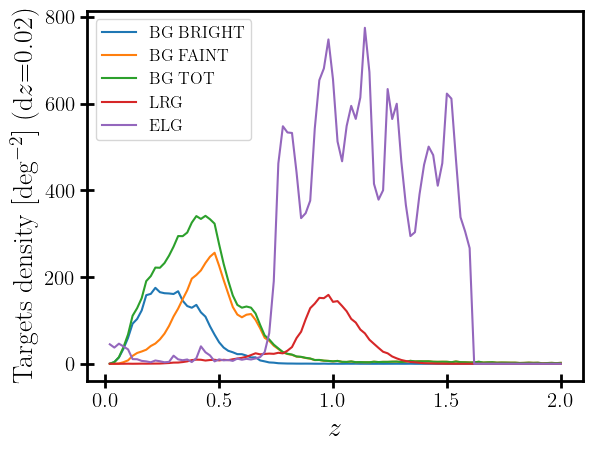

In [28]:
plt.plot(Nz_BG_BRIGHT[1][1::],Nz_BG_BRIGHT[0]/AREA_SWEEP,label='BG BRIGHT')
plt.plot(Nz_BG_FAINT[1][1::],Nz_BG_FAINT[0]/AREA_SWEEP,label='BG FAINT')
plt.plot(Nz_BG_BRIGHT[1][1::],Nz_BG_TOT/AREA_SWEEP,label = 'BG TOT')
plt.plot(Nz_LRG[1][1::],Nz_LRG[0]/AREA_SWEEP,label='LRG')
plt.plot(Nz_ELG[1][1::],Nz_ELG[0]/AREA_COSMOS,label='ELG')
plt.xlabel(r'$z$')
plt.ylabel(r'Targets density [deg$^{-2}$] (d$z$=0.02)')
plt.legend()
plt.show()
plt.close()

In [29]:
z3D_BG_BRIGHT, n3D_BG_BRIGHT = get_3D_sample(phot_z_SWEEP,BG_WST_Bright,AREA_SWEEP)
z3D_BG_FAINT, n3D_BG_FAINT = get_3D_sample(phot_z_SWEEP,BG_WST_Faint,AREA_SWEEP)
n3D_BG_TOT = n3D_BG_BRIGHT + n3D_BG_FAINT
z3D_LRG, n3D_LRG = get_3D_sample(phot_z_SWEEP,LRG_WST,AREA_SWEEP)
z3D_ELG, n3D_ELG = get_3D_sample(phot_z_COSMOS,ELG_WST,AREA_COSMOS)

Target Density : 2934.1356673960613
Target Density : 4250.929978118162
Target Density : 2509.5185995623633
Target Density : 22164.615901096175


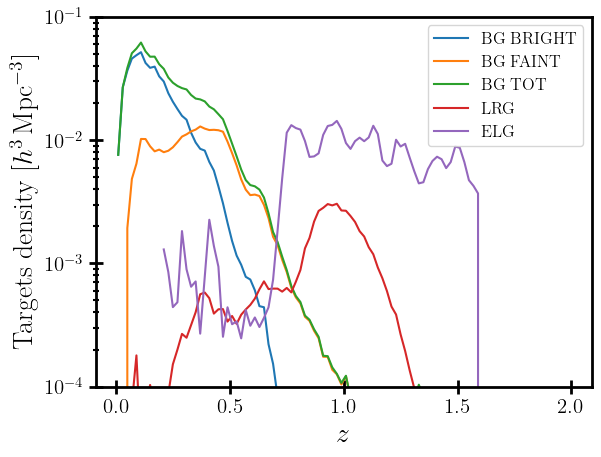

In [30]:
plt.plot(z3D_BG_BRIGHT,n3D_BG_BRIGHT,label='BG BRIGHT')
plt.plot(z3D_BG_FAINT,n3D_BG_FAINT,label='BG FAINT')
plt.plot(z3D_BG_BRIGHT,n3D_BG_TOT,label='BG TOT')
plt.plot(z3D_LRG,n3D_LRG,label='LRG')
plt.plot(z3D_ELG[10::],n3D_ELG[10::],label='ELG')
plt.xlabel(r'$z$')
plt.ylabel(r'Targets density [$h^3$\,Mpc$^{-3}$]')
plt.yscale('log')
plt.ylim(1e-4,0.1)
plt.legend()
plt.show()
plt.close()

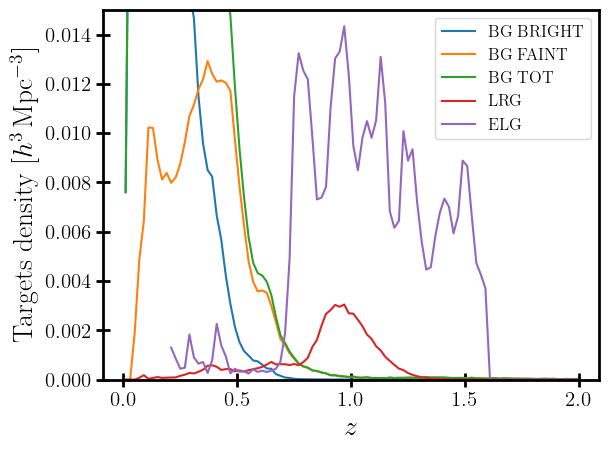

In [31]:
plt.plot(z3D_BG_BRIGHT,n3D_BG_BRIGHT,label='BG BRIGHT')
plt.plot(z3D_BG_FAINT,n3D_BG_FAINT,label='BG FAINT')
plt.plot(z3D_BG_BRIGHT,n3D_BG_TOT,label='BG TOT')
plt.plot(z3D_LRG,n3D_LRG,label='LRG')
plt.plot(z3D_ELG[10::],n3D_ELG[10::],label='ELG')
plt.ylim(0,0.015)
plt.xlabel(r'$z$')
plt.ylabel(r'Targets density [$h^3$\,Mpc$^{-3}$]')
plt.legend()
plt.show()
plt.close()

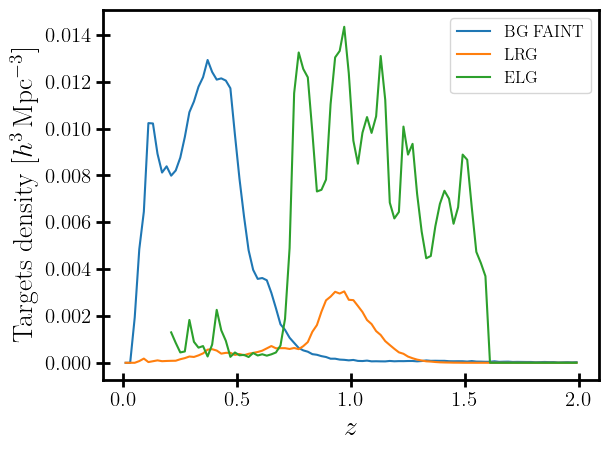

In [32]:
#plt.plot(z3D_BG_BRIGHT,n3D_BG_BRIGHT,label='BG BRIGHT')
plt.plot(z3D_BG_FAINT,n3D_BG_FAINT,label='BG FAINT')
#plt.plot(z3D_BG_BRIGHT,n3D_BG_TOT,label='BG TOT')
plt.plot(z3D_LRG,n3D_LRG,label='LRG')
plt.plot(z3D_ELG[10::],n3D_ELG[10::],label='ELG')
plt.xlabel(r'$z$')
plt.ylabel(r'Targets density [$h^3$\,Mpc$^{-3}$]')
plt.legend()
plt.show()
plt.close()

In [33]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

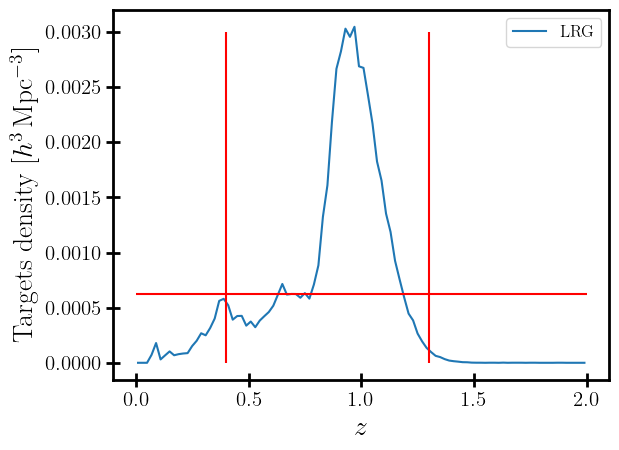

In [34]:
plt.plot(z3D_LRG,n3D_LRG,label='LRG')
test = np.median(n3D_LRG[(z3D_LRG>0.4) & (z3D_LRG<1.3)])
plt.vlines((0.4,1.3),0,0.003,'r')
plt.hlines(test,0,2,'r')
plt.xlabel(r'$z$')
plt.ylabel(r'Targets density [$h^3$\,Mpc$^{-3}$]')
plt.legend()
plt.show()
plt.close()

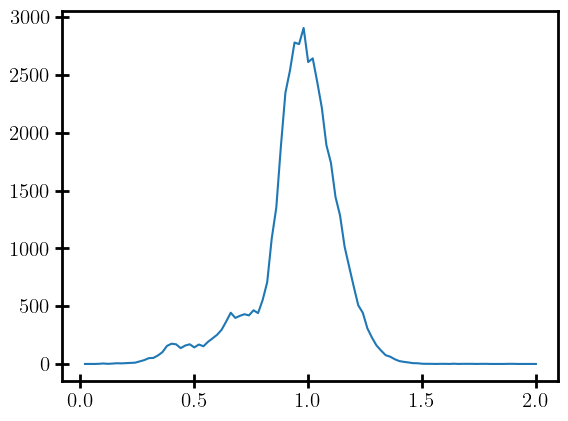

In [35]:
plt.plot(Nz_LRG[1][1::],Nz_LRG[0],label='LRG')
plt.show()

In [36]:
mask_z_lrg_test = (Nz_LRG[1][1::] > 0.4) & (Nz_LRG[1][1::] < 1.3)

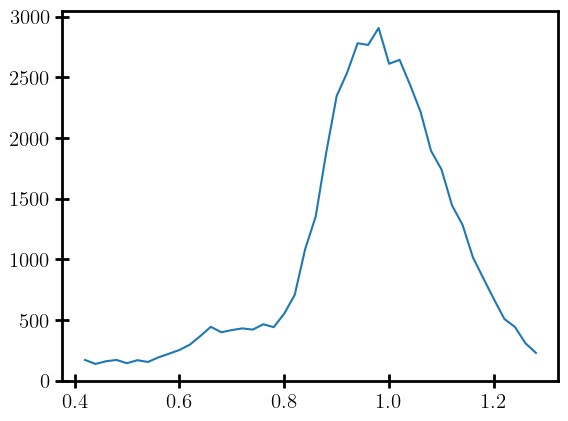

In [37]:
plt.plot(Nz_LRG[1][1::][mask_z_lrg_test],Nz_LRG[0][mask_z_lrg_test],label='LRG')
plt.show()

In [38]:
Nz_LRG[0].sum()

45871

In [39]:
len(Nz_LRG[1][1::][mask_z_lrg_test])

44

In [40]:
Nz_LRG[0].sum() / len(Nz_LRG[1][1::][mask_z_lrg_test])

1042.5227272727273

In [41]:
test_LRG_nz = np.zeros_like(Nz_LRG[1][1::][mask_z_lrg_test]) + Nz_LRG[0].sum() / len(Nz_LRG[1][1::][mask_z_lrg_test])

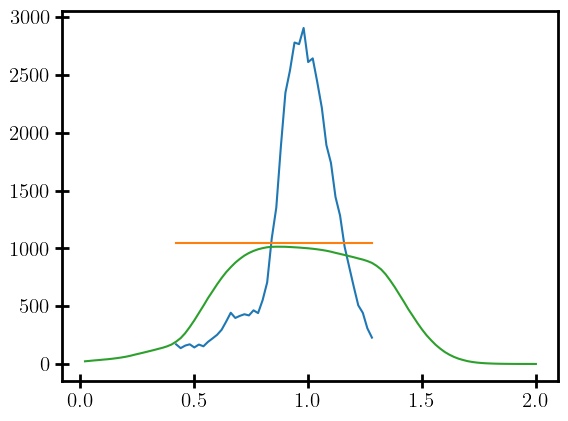

In [42]:
plt.plot(Nz_LRG[1][1::][mask_z_lrg_test],Nz_LRG[0][mask_z_lrg_test],label='LRG')
plt.plot(Nz_LRG[1][1::][mask_z_lrg_test],test_LRG_nz)
plt.plot(Nz_LRG[1][1::],smooth(Nz_LRG[0],44),label='LRG')
plt.show()

In [43]:
smooth(Nz_LRG[0],44).sum()

45790.090909090904

In [44]:
def get_3D_sample_LRG_SPECIAL(photo_z_col,sample_mask,AREA):
    photo_z_sample = photo_z_col[sample_mask & (photo_z_col > 0)]
    print('Target Density : ' + str(len(photo_z_sample)/AREA))
    photz_liste = np.linspace(0,2,101)
    N_bins = np.histogram(photo_z_sample, bins = photz_liste)
    z_sample,n3D_sample = compute_volume(N_bins[1],smooth(N_bins[0],44),AREA)
    return z_sample, n3D_sample

def get_3D_sample_ELG_SPECIAL(photo_z_col,sample_mask,AREA):
    photo_z_sample = photo_z_col[sample_mask & (photo_z_col > 0)]
    print('Target Density : ' + str(len(photo_z_sample)/AREA))
    photz_liste = np.linspace(0,2,101)
    N_bins = np.histogram(photo_z_sample, bins = photz_liste)
    z_sample,n3D_sample = compute_volume(N_bins[1],smooth(N_bins[0],12),AREA)
    return z_sample, n3D_sample

In [45]:
z3D_LRG_test, n3D_LRG_test = get_3D_sample_LRG_SPECIAL(phot_z_SWEEP,LRG_WST,AREA_SWEEP)
z3D_ELG_test, n3D_ELG_test = get_3D_sample_ELG_SPECIAL(phot_z_COSMOS,ELG_WST,AREA_COSMOS)

Target Density : 2509.5185995623633
Target Density : 22164.615901096175


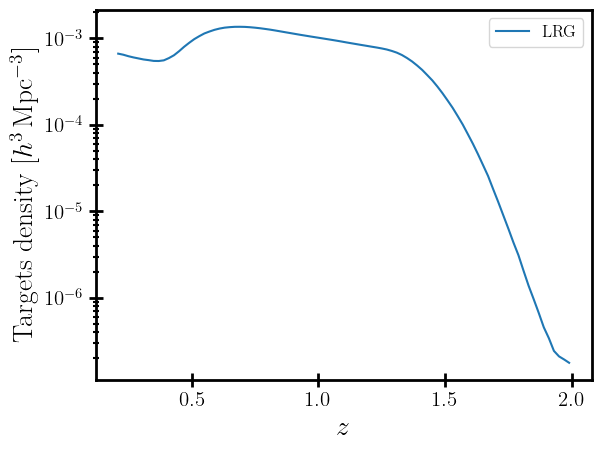

In [46]:
plt.plot(z3D_LRG_test[10::],n3D_LRG_test[10::],label='LRG')
plt.xlabel(r'$z$')
plt.ylabel(r'Targets density [$h^3$\,Mpc$^{-3}$]')
plt.legend()
plt.yscale('log')
plt.show()
plt.close()

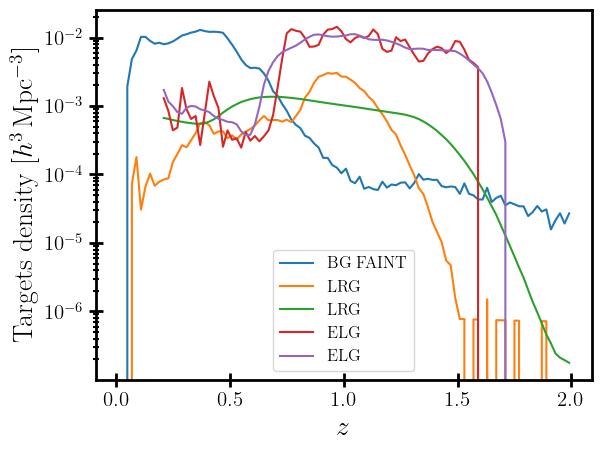

In [47]:
#plt.plot(z3D_BG_BRIGHT,n3D_BG_BRIGHT,label='BG BRIGHT')
plt.plot(z3D_BG_FAINT,n3D_BG_FAINT,label='BG FAINT')
#plt.plot(z3D_BG_BRIGHT,n3D_BG_TOT,label='BG TOT')
plt.plot(z3D_LRG,n3D_LRG,label='LRG')
plt.plot(z3D_LRG_test[10::],n3D_LRG_test[10::],label='LRG')
plt.plot(z3D_ELG[10::],n3D_ELG[10::],label='ELG')
plt.plot(z3D_ELG[10::],n3D_ELG_test[10::],label='ELG')
plt.xlabel(r'$z$')
plt.ylabel(r'Targets density [$h^3$\,Mpc$^{-3}$]')
plt.legend()
plt.yscale('log')
plt.show()
plt.close()

In [48]:
print(n3D_LRG.sum(),smooth(n3D_LRG,smooth_lim).sum(), (n3D_LRG.sum()-smooth(n3D_LRG,smooth_lim).sum())/n3D_LRG.sum()*100)

NameError: name 'smooth_lim' is not defined

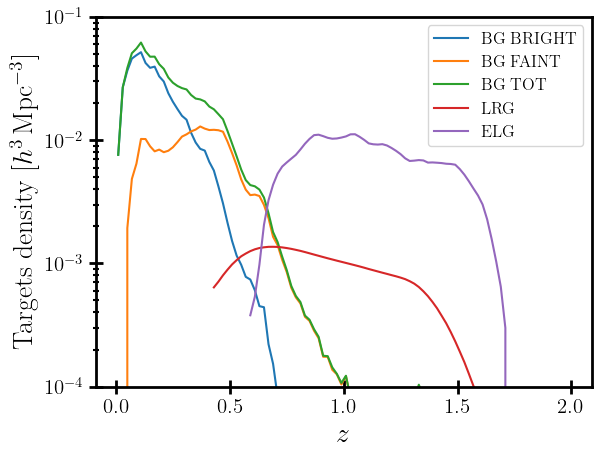

In [49]:
plt.plot(z3D_BG_BRIGHT,n3D_BG_BRIGHT,label='BG BRIGHT')
plt.plot(z3D_BG_FAINT,n3D_BG_FAINT,label='BG FAINT')
plt.plot(z3D_BG_BRIGHT,n3D_BG_TOT,label='BG TOT')
plt.plot(z3D_LRG[21::],n3D_LRG_test[21::],label='LRG')
plt.plot(z3D_ELG_test[29::],n3D_ELG_test[29::],label='ELG')
plt.xlabel(r'$z$')
plt.ylabel(r'Targets density [$h^3$\,Mpc$^{-3}$]')
plt.yscale('log')
plt.ylim(1e-4,0.1)
plt.legend()
plt.show()
plt.close()

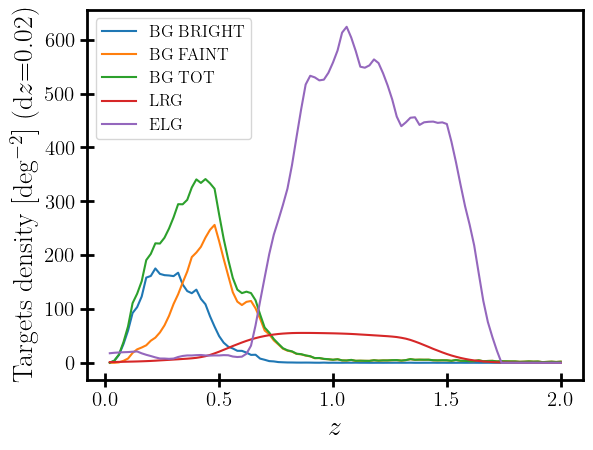

In [50]:
plt.plot(Nz_BG_BRIGHT[1][1::],Nz_BG_BRIGHT[0]/AREA_SWEEP,label='BG BRIGHT')
plt.plot(Nz_BG_FAINT[1][1::],Nz_BG_FAINT[0]/AREA_SWEEP,label='BG FAINT')
plt.plot(Nz_BG_BRIGHT[1][1::],Nz_BG_TOT/AREA_SWEEP,label = 'BG TOT')
plt.plot(Nz_LRG[1][1::],smooth(Nz_LRG[0],44)/AREA_SWEEP,label='LRG')
plt.plot(Nz_ELG[1][1::],smooth(Nz_ELG[0],12)/AREA_COSMOS,label='ELG')
plt.xlabel(r'$z$')
plt.ylabel(r'Targets density [deg$^{-2}$] (d$z$=0.02)')
plt.legend()
plt.show()
plt.close()

In [51]:
n3D_LRG_test_cut = n3D_LRG_test
n3D_ELG_test_cut = n3D_ELG_test
n3D_LRG_test_cut[0:21] = 0
n3D_ELG_test_cut[0:29] = 0

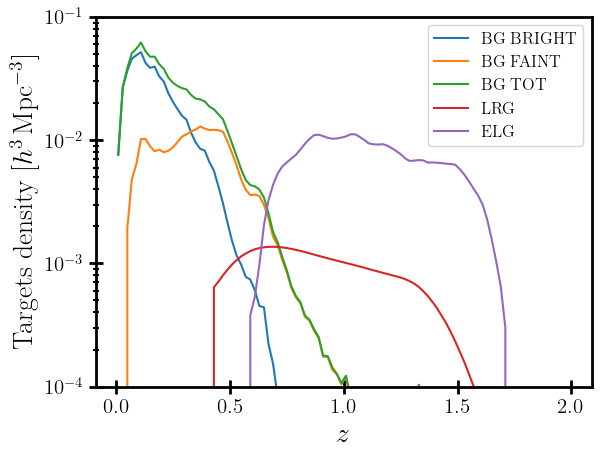

In [52]:
plt.plot(z3D_BG_BRIGHT,n3D_BG_BRIGHT,label='BG BRIGHT')
plt.plot(z3D_BG_FAINT,n3D_BG_FAINT,label='BG FAINT')
plt.plot(z3D_BG_BRIGHT,n3D_BG_TOT,label='BG TOT')
plt.plot(z3D_LRG,n3D_LRG_test_cut,label='LRG')
plt.plot(z3D_ELG,n3D_ELG_test_cut,label='ELG')
plt.xlabel(r'$z$')
plt.ylabel(r'Targets density [$h^3$\,Mpc$^{-3}$]')
plt.yscale('log')
plt.ylim(1e-4,0.1)
plt.legend()
plt.show()
plt.close()

In [53]:
(Nz_BG_FAINT[0]/AREA_SWEEP + smooth(Nz_LRG[0],44)/AREA_SWEEP + smooth(Nz_ELG[0],12)/AREA_COSMOS).sum()

28826.559308880165

In [58]:
z_final = z3D_BG_BRIGHT
dz = np.round(z_final[1] - z_final[0],2)
print(dz)
dz=1

Nz_BG_BRIGHT_final = Nz_BG_BRIGHT[0]/(AREA_SWEEP*dz)
Nz_BG_FAINT_final = Nz_BG_FAINT[0]/(AREA_SWEEP*dz)
Nz_LRG_final = smooth(Nz_LRG[0],44)/(AREA_SWEEP*dz)
Nz_LRG_final_cut = Nz_LRG_final
Nz_LRG_final_cut[0:21] = 0
Nz_ELG_final = smooth(Nz_ELG[0],12)/(AREA_COSMOS*dz)
Nz_ELG_final_cut = Nz_ELG_final
Nz_ELG_final_cut[0:29] = 0

NzV_BG_BRIGHT_final = n3D_BG_BRIGHT/dz
NzV_BG_FAINT_final = n3D_BG_FAINT/dz
NzV_LRG_final = n3D_LRG_test_cut/dz
NzV_ELG_final = n3D_ELG_test_cut/dz

0.02


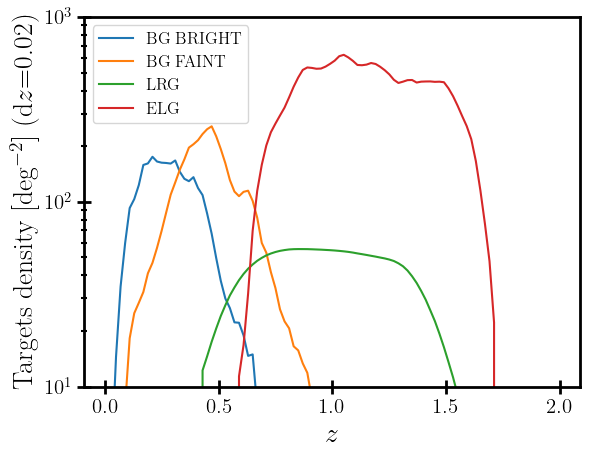

In [65]:
plt.plot(z_final,Nz_BG_BRIGHT_final,label='BG BRIGHT')
plt.plot(z_final,Nz_BG_FAINT_final,label='BG FAINT')
plt.plot(z_final,Nz_LRG_final_cut,label='LRG')
plt.plot(z_final,Nz_ELG_final,label='ELG')
plt.xlabel(r'$z$')
plt.ylabel(r'Targets density [deg$^{-2}$] (d$z$=0.02)')
plt.legend()
plt.yscale('log')
plt.ylim(10,1000)
plt.show()
plt.close()

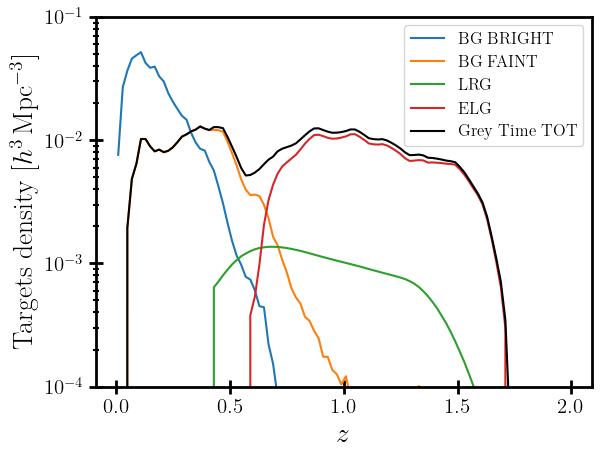

In [69]:
plt.plot(z_final,NzV_BG_BRIGHT_final,label='BG BRIGHT')
plt.plot(z_final,NzV_BG_FAINT_final,label='BG FAINT')
plt.plot(z_final,NzV_LRG_final,label='LRG')
plt.plot(z_final,NzV_ELG_final,label='ELG')
plt.plot(z_final,NzV_BG_FAINT_final + NzV_LRG_final + NzV_ELG_final,'k',label='Grey Time TOT')
plt.xlabel(r'$z$')
plt.ylabel(r'Targets density [$h^3$\,Mpc$^{-3}$]')
plt.yscale('log')
plt.ylim(1e-4,0.1)
plt.legend()
plt.show()
plt.close()

In [61]:
np.savetxt('BG_BRIGHT.txt', np.array([z_final, Nz_BG_BRIGHT_final, NzV_BG_BRIGHT_final]).T)
np.savetxt('BG_FAINT.txt', np.array([z_final, Nz_BG_FAINT_final, NzV_BG_FAINT_final]).T)
np.savetxt('LRG.txt', np.array([z_final, Nz_LRG_final, NzV_LRG_final]).T)
np.savetxt('ELG.txt', np.array([z_final, Nz_ELG_final, NzV_ELG_final]).T)

In [89]:
np.savetxt('BG_BRIGHT_FINAL.txt', np.array([z_final, NzV_BG_BRIGHT_final,z_final - 0.01, z_final + 0.01, Nz_BG_BRIGHT_final*AREA_SWEEP]).T,header='z_mean h³Mpc⁻³ z_min z_max N_targets')
np.savetxt('BG_FAINT_FINAL.txt', np.array([z_final, NzV_BG_FAINT_final,z_final - 0.01, z_final + 0.01, Nz_BG_FAINT_final*AREA_SWEEP]).T,header='z_mean h³Mpc⁻³ z_min z_max N_targets')
np.savetxt('LRG_FINAL.txt', np.array([z_final, NzV_LRG_final,z_final - 0.01, z_final + 0.01, Nz_LRG_final*AREA_SWEEP]).T,header='z_mean h³Mpc⁻³ z_min z_max N_targets')
np.savetxt('ELG_FINAL.txt', np.array([z_final, NzV_ELG_final,z_final - 0.01, z_final + 0.01, Nz_ELG_final*AREA_COSMOS]).T,header='z_mean h³Mpc⁻³ z_min z_max N_targets')

In [33]:
z_BGS_faint,n_BGS_faint, n_BGS_faint_V =np.loadtxt('nz_wst_bg_faint.txt',skiprows=1,unpack=True)
z_BGS_bright,n_BGS_bright, n_BGS_bright_V =np.loadtxt('nz_wst_bg_bright.txt',skiprows=1,unpack=True)
z_ELG,n_ELG, n_ELG_V =np.loadtxt('nz_wst_elg.txt',skiprows=1,unpack=True)
z_LRG,n_LRG, n_LRG_V =np.loadtxt('nz_wst_lrg.txt',skiprows=1,unpack=True)

In [34]:
z_QSO, n_QSO, n_QSO_V = np.loadtxt('nz_wst_qso.txt',skiprows=1,unpack=True)
z_LBGU, n_LBGU, n_LBGU_V = np.loadtxt('nz_wst_lbg-u.txt',skiprows=1,unpack=True)
z_LBGUext, n_LBGUext, n_LBGUext_V = np.loadtxt('nz_wst_lbg-uext.txt',skiprows=1,unpack=True)
z_LBGG, n_LBGG, n_LBGG_V = np.loadtxt('nz_wst_lbg-g.txt',skiprows=1,unpack=True)
z_LBGR, n_LBGR, n_LBGR_V = np.loadtxt('nz_wst_lbg-r.txt',skiprows=1,unpack=True)

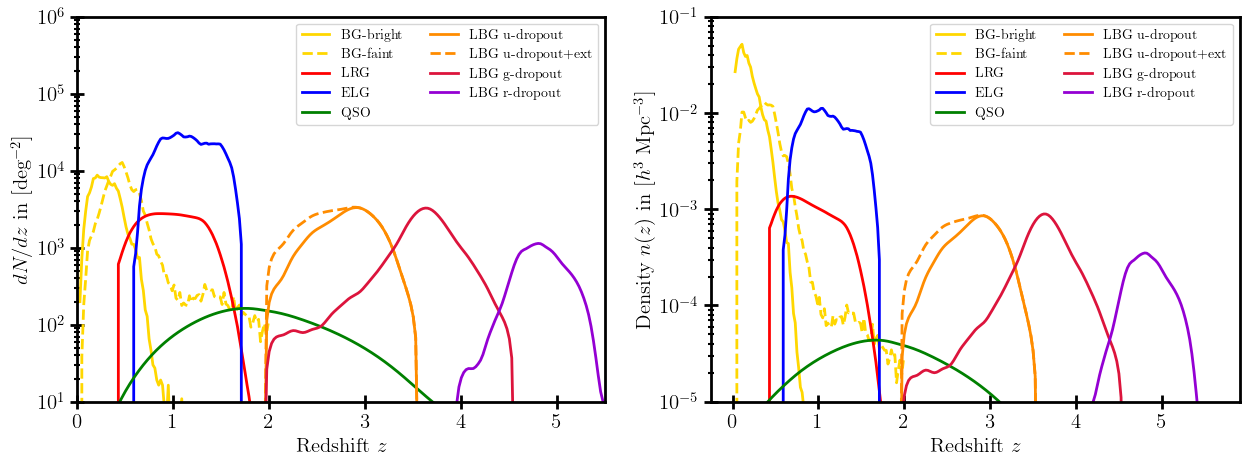

In [36]:
plt.figure(dpi=100, figsize=(15, 5))
plt.subplot(121)
plt.plot(z_BGS_bright, n_BGS_bright, '-', label='BG-bright',c='gold', lw=2)
plt.plot(z_BGS_faint, n_BGS_faint, label='BG-faint', ls='--',c='gold', lw=2)
plt.plot(z_LRG, n_LRG, label='LRG',c='red', lw=2)
plt.plot(z_ELG, n_ELG, label='ELG',c='blue', lw=2)
#print('BGS_bright density : '+str(round(np.trapezoid(n_BGS_bright, z_BGS_bright))) + ' deg-2')
#print('BGS_faint density  : '+str(round(np.trapezoid(n_BGS_faint, z_BGS_faint))) + ' deg-2')
#print('LRG density        : '+str(round(np.trapezoid(n_LRG, z_LRG))) + ' deg-2')
#print('ELG density        : '+str(round(np.trapezoid(n_ELG, z_ELG))) + ' deg-2')
print()
plt.plot(z_QSO, n_QSO, label='QSO',c='green', lw=2)
#print('QSO density               : '+str(round(np.trapezoid(n_QSO, z_QSO))) + ' deg-2')
plt.plot(z_LBGU, n_LBGU, c='darkorange',label='LBG u-dropout', lw=2)
#print('LBG u-dropout density     : '+str(round(np.trapezoid(n_LBGU, z_LBGU))) + ' deg-2')
plt.plot(z_LBGUext, n_LBGUext,c='darkorange',linestyle='--',label='LBG u-dropout+ext ' ,lw=2)
#print('LBG u-dropout-ext density : '+str(round(np.trapezoid(n_LBGUext, z_LBGUext))) + ' deg-2')
plt.plot(z_LBGG, n_LBGG,c='crimson',label='LBG g-dropout ' ,lw=2)
#print('LBG g-dropout density     : '+str(round(np.trapezoid(n_LBGG, z_LBGG))) + ' deg-2')
plt.plot(z_LBGR, n_LBGR,c='darkviolet',label='LBG r-dropout ' ,lw=2)
#print('LBG r-dropout             : '+str(round(np.trapezoid(n_LBGR, z_LBGR))) + ' deg-2')

plt.xlim(0.,5.5)
plt.ylim(10,1000000)
plt.yscale('log')
plt.ylabel('$dN/dz$ in [deg$^{-2}$]',fontsize=15)
plt.xlabel('Redshift $z$',fontsize=15)
plt.legend(fontsize=10, ncols=2)


plt.subplot(122)

plt.plot(z_BGS_bright, n_BGS_bright_V*0.02, '-', label='BG-bright',c='gold', lw=2)
plt.plot(z_BGS_faint, n_BGS_faint_V*0.02, label='BG-faint', ls='--',c='gold', lw=2)
plt.plot(z_LRG, n_LRG_V*0.02, label='LRG',c='red', lw=2)
plt.plot(z_ELG, n_ELG_V*0.02, label='ELG',c='blue', lw=2)
plt.plot(z_QSO, n_QSO_V, label='QSO',c='green', lw=2)

plt.plot(z_LBGU, n_LBGU_V, c='darkorange',label='LBG u-dropout', lw=2)
plt.plot(z_LBGUext, n_LBGUext_V,c='darkorange',linestyle='--',label='LBG u-dropout+ext ' ,lw=2)
plt.plot(z_LBGG, n_LBGG_V,c='crimson',label='LBG g-dropout ' ,lw=2)
plt.plot(z_LBGR, n_LBGR_V,c='darkviolet',label='LBG r-dropout ' ,lw=2)

plt.ylabel('Density $n(z)$ in [$h^3$ Mpc$^{-3}$]',fontsize=15)
plt.xlabel('Redshift $z$',fontsize=15)
plt.ylim(1e-5,0.1)
plt.yscale('log')
plt.legend(fontsize=10, ncols=2)

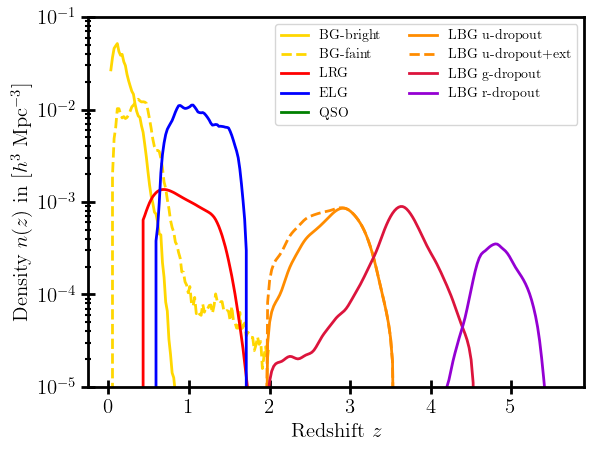

In [37]:
plt.plot(z_BGS_bright, n_BGS_bright_V*0.02, '-', label='BG-bright',c='gold', lw=2)
plt.plot(z_BGS_faint, n_BGS_faint_V*0.02, label='BG-faint', ls='--',c='gold', lw=2)
plt.plot(z_LRG, n_LRG_V*0.02, label='LRG',c='red', lw=2)
plt.plot(z_ELG, n_ELG_V*0.02, label='ELG',c='blue', lw=2)
plt.plot(z_QSO, n_QSO_V*0.02, label='QSO',c='green', lw=2)

plt.plot(z_LBGU, n_LBGU_V, c='darkorange',label='LBG u-dropout', lw=2)
plt.plot(z_LBGUext, n_LBGUext_V,c='darkorange',linestyle='--',label='LBG u-dropout+ext ' ,lw=2)
plt.plot(z_LBGG, n_LBGG_V,c='crimson',label='LBG g-dropout ' ,lw=2)
plt.plot(z_LBGR, n_LBGR_V,c='darkviolet',label='LBG r-dropout ' ,lw=2)

plt.ylabel('Density $n(z)$ in [$h^3$ Mpc$^{-3}$]',fontsize=15)
plt.xlabel('Redshift $z$',fontsize=15)
plt.ylim(1e-5,0.1)
plt.yscale('log')
plt.legend(fontsize=10, ncols=2)
plt.show()